In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio
from scipy import stats

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 5, 'ytick.major.width': 1, 'ytick.major.size': 5})
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.gridspec as gridspec

In [2]:
def get_table_icd_helper(ser, comorbidity):
    table = [
        [ser[f"gene_{comorbidity}"], ser[f"gene_non{comorbidity}"]],
        [ser[f"nongene_{comorbidity}"], ser[f"nongene_non{comorbidity}"]]
    ]
    res = fisher_exact(table)
    or_study = odds_ratio(table)
    cil, cih = or_study.confidence_interval(confidence_level=0.95)
    return pd.Series({"ID": ser.ID, "comorbidity": comorbidity, "OR": res.statistic, "p_value": res.pvalue, "ci_low": cil, "ci_high": cih})



In [3]:
aou_df = pd.read_csv("../data/bmi_cat_enrichment/monogenic_aou_bmi_cat.csv.gz", index_col=0)
ukb_df = pd.read_csv("../data/bmi_cat_enrichment/monogenic_ukb_bmi_cat.csv.gz", index_col=0)


In [4]:
meta_df = aou_df+ukb_df
meta_df = meta_df.reset_index()

In [5]:

RERUN=False
if RERUN: 
    df = pd.DataFrame()
    comorbidities = ["nu", "ob", "sob", "ovw"]
    for comorbidity in comorbidities:
        cdf = meta_df.apply(get_table_icd_helper, axis=1, args=(comorbidity,))
        df = pd.concat((df, cdf))
    df.to_excel("../data/bmi_cat_enrichment/monogenic_bmi_categories.xlsx")

In [6]:
thresh=1.5

bmi_cat_df = pd.read_excel("../data/bmi_cat_enrichment/monogenic_bmi_categories.xlsx")
mono_meta_df = pd.read_excel("../data/meta/monogenic_meta.xlsx")
mono_meta_df["gene"] = mono_meta_df.ID.str.split(".", expand=True).iloc[:, 0]
# Add a new column to store the absolute values of beta
mono_meta_df['abs_beta'] = mono_meta_df['beta'].abs()
max_beta_df = mono_meta_df.loc[mono_meta_df.groupby('gene')['abs_beta'].idxmax()].sort_values("abs_beta", ascending=False)
thresh_beta_genes = max_beta_df.loc[max_beta_df.abs_beta>thresh, "ID"]
protective_genes = max_beta_df.loc[max_beta_df.beta<-thresh, "ID"]
risk_genes = max_beta_df.loc[max_beta_df.beta>thresh, "ID"]

thresh_meta_df = meta_df.loc[meta_df.ID.isin(thresh_beta_genes)]
thresh_meta_df["gene"] = thresh_meta_df.ID.str.split(".", expand=True).iloc[:, 0]
thresh_meta_long_df = thresh_meta_df.melt(id_vars=["gene", "ID"],  value_vars=["gene_nu", "gene_ovw", "gene_ob", "gene_sob"], var_name="category", value_name="nsamples")
thresh_meta_long_df["category"] = thresh_meta_long_df.category.map({"gene_nu": "underweight_normal", "gene_ovw": "overweight", "gene_ob": "obese", "gene_sob": "severely_obese"})
total_samples_per_gene = thresh_meta_long_df.groupby("gene")["nsamples"].transform("sum")
thresh_meta_long_df["percent"] = thresh_meta_long_df["nsamples"].div(total_samples_per_gene)*100
thresh_meta_long_df = thresh_meta_long_df.set_index("ID").loc[pd.concat((risk_genes, protective_genes))].reset_index()
genes = thresh_meta_long_df.gene.unique()
cwc = dict()

bmi_categories = ["underweight_normal", "overweight", "obese", "severely_obese"]

for cat in bmi_categories:
    cwc[cat] = thresh_meta_long_df.loc[thresh_meta_long_df.category==cat, "percent"].values

bmi_cat_df = bmi_cat_df.loc[bmi_cat_df.ID.isin(thresh_meta_long_df.ID)]
bmi_cat_df["gene"] = bmi_cat_df.ID.str.split(".", expand=True).iloc[:, 0]
bmi_cat_df["comorbidity"] = bmi_cat_df.comorbidity.map({"nu": "underweight_normal", "ovw": "overweight", "ob": "obese", "sob": "severely_obese"})

/var/folders/nc/7c09ww457r580z0qc6055g8m0000gn/T/ipykernel_74734/3252208586.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresh_meta_df["gene"] = thresh_meta_df.ID.str.split(".", expand=True).iloc[:, 0]


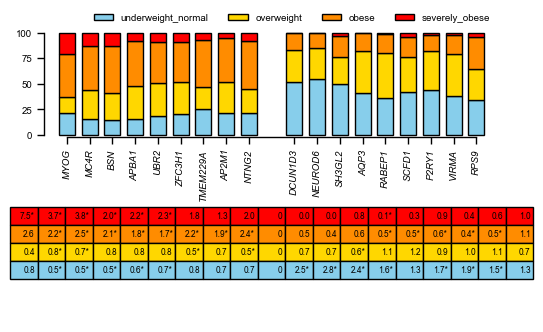

In [7]:
width = 0.7

fig = plt.figure(figsize=(6.5, 3.5)) #, (ax1, ax2) = plt.subplots(2,1, figsize=(4, 6), height_ratios=(3, 3), sharex=True)

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1.5])

# Create the bar plots
ax1 = fig.add_subplot(gs[0])
# ax2 = fig.add_subplot(gs[1])

colors = ["skyblue", "gold", "darkorange", "red"] #sns.color_palette("tab20", 5)
positions1 = [i for i in range(len(risk_genes))] + [i+len(risk_genes)+1 for i in range(len(protective_genes))]#-0.2
bottom = np.zeros(len(risk_genes)+len(protective_genes))
for bmi_cat,col in zip(bmi_categories, colors):
    weight_count = cwc[bmi_cat]
    p = ax1.bar(positions1, weight_count, width, label=bmi_cat, bottom=bottom, color=col, edgecolor="k")
    bottom += weight_count

# Add a table at the bottom of the Axes

cell_text = []
cell_colors = []
    
for obese_spec, color in zip(bmi_categories[::-1], colors[::-1]):
    OR = []
    for gene in list(risk_genes)+["NA"]+list(protective_genes):
        if gene=="NA":
            orr=0
            pval=1
        else:
            gene = gene.split(".")[0]
            orr = bmi_cat_df.loc[(bmi_cat_df.gene==gene)&(bmi_cat_df.comorbidity==obese_spec), "OR"].values[0]
            pval = bmi_cat_df.loc[(bmi_cat_df.gene==gene)&(bmi_cat_df.comorbidity==obese_spec), "p_value"].values[0]
        starp=""
        if pval<0.05:
            starp="*"
        OR.append(str(round(orr, 1))+starp)
    cell_text.append(OR)
    cell_colors.append([color for _ in range(len(list(risk_genes)+["NA"]+list(protective_genes)))])

ax_table = fig.add_subplot(gs[1])
ax_table.axis('off')
the_table = ax_table.table(cellText=cell_text,
                           cellColours=cell_colors,
                        #    rowLabels=["overweight", "obese", "severely obese"],
                        #    rowColours=colors[2:],
                        #    colLabels=[f"{i}" for i in range(1, 11)],
                           loc='center', cellLoc="right", rowLoc="center")


# Adjust the table's positioning
# the_table.auto_set_font_size(False)
the_table.set_fontsize(6)
the_table.scale(1.15, 1.)  # Adjust the scale to fit the plot

ax1.legend(loc=(0.1, 1.05), ncol=4, frameon=False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.set_xticks(positions1, genes, fontsize=7, fontstyle="italic", rotation=90)
ax1.set_xlim(-1, len(genes)+1)

ax1.set_ylim(-2, 101)
ax1.spines['bottom'].set_bounds(ax1.get_xticks()[0], ax1.get_xticks()[-1])
ax1.spines['left'].set_bounds(0, 100);

plt.subplots_adjust(left=0.2, bottom=0.05)

# Add connecting lines


In [48]:
def save_pdf(save_file, fig):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return

In [49]:
save_pdf("../data/bmi_cat_enrichment/high_effect_genes_v2.pdf", fig)

In [50]:
thresh=1

bmi_cat_df = pd.read_excel("../data/bmi_cat_enrichment/monogenic_bmi_categories.xlsx")
mono_meta_df = pd.read_excel("../data/meta/monogenic_meta.xlsx")
mono_meta_df["gene"] = mono_meta_df.ID.str.split(".", expand=True).iloc[:, 0]
# Add a new column to store the absolute values of beta
mono_meta_df['abs_beta'] = mono_meta_df['beta'].abs()
max_beta_df = mono_meta_df.loc[mono_meta_df.groupby('gene')['abs_beta'].idxmax()].sort_values("abs_beta", ascending=False)
thresh_beta_genes = max_beta_df.loc[max_beta_df.abs_beta.between(1, 1.5), "ID"]
protective_genes = max_beta_df.loc[max_beta_df.beta.between(-1.5, -1), "ID"]
risk_genes = max_beta_df.loc[max_beta_df.beta.between(1, 1.5), "ID"]
thresh_meta_df = meta_df.loc[meta_df.ID.isin(thresh_beta_genes)]
thresh_meta_df["gene"] = thresh_meta_df.ID.str.split(".", expand=True).iloc[:, 0]
thresh_meta_long_df = thresh_meta_df.melt(id_vars=["gene", "ID"],  value_vars=["gene_nu", "gene_ovw", "gene_ob", "gene_sob"], var_name="category", value_name="nsamples")
thresh_meta_long_df["category"] = thresh_meta_long_df.category.map({"gene_nu": "underweight_normal", "gene_ovw": "overweight", "gene_ob": "obese", "gene_sob": "severely_obese"})
total_samples_per_gene = thresh_meta_long_df.groupby("gene")["nsamples"].transform("sum")
thresh_meta_long_df["percent"] = thresh_meta_long_df["nsamples"].div(total_samples_per_gene)*100
thresh_meta_long_df = thresh_meta_long_df.set_index("ID").loc[pd.concat((risk_genes, protective_genes))].reset_index()
genes = thresh_meta_long_df.gene.unique()
cwc = dict()

bmi_categories = ["underweight_normal", "overweight", "obese", "severely_obese"]

for cat in bmi_categories:
    cwc[cat] = thresh_meta_long_df.loc[thresh_meta_long_df.category==cat, "percent"].values

bmi_cat_df = bmi_cat_df.loc[bmi_cat_df.ID.isin(thresh_meta_long_df.ID)]
bmi_cat_df["gene"] = bmi_cat_df.ID.str.split(".", expand=True).iloc[:, 0]
bmi_cat_df["comorbidity"] = bmi_cat_df.comorbidity.map({"nu": "underweight_normal", "ovw": "overweight", "ob": "obese", "sob": "severely_obese"})

/var/folders/nc/7c09ww457r580z0qc6055g8m0000gn/T/ipykernel_9950/827837760.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresh_meta_df["gene"] = thresh_meta_df.ID.str.split(".", expand=True).iloc[:, 0]


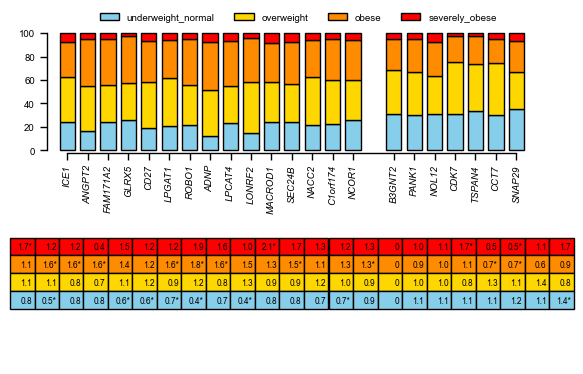

In [52]:
width = 0.75

fig = plt.figure(figsize=(7, 4)) #, (ax1, ax2) = plt.subplots(2,1, figsize=(4, 6), height_ratios=(3, 3), sharex=True)

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1.5])

# Create the bar plots
ax1 = fig.add_subplot(gs[0])
# ax2 = fig.add_subplot(gs[1])

colors = ["skyblue", "gold", "darkorange", "red"] #sns.color_palette("tab20", 5)
positions1 = [i for i in range(len(risk_genes))] + [i+len(risk_genes)+1 for i in range(len(protective_genes))]#-0.2
bottom = np.zeros(len(risk_genes)+len(protective_genes))
for bmi_cat,col in zip(bmi_categories, colors):
    weight_count = cwc[bmi_cat]
    p = ax1.bar(positions1, weight_count, width, label=bmi_cat, bottom=bottom, color=col, edgecolor="k")
    bottom += weight_count

# Add a table at the bottom of the Axes

cell_text = []
cell_colors = []
    
for obese_spec, color in zip(bmi_categories[::-1], colors[::-1]):
    OR = []
    for gene in list(risk_genes)+["NA"]+list(protective_genes):
        if gene=="NA":
            orr=0
            pval=1
        else:
            gene = gene.split(".")[0]
            orr = bmi_cat_df.loc[(bmi_cat_df.gene==gene)&(bmi_cat_df.comorbidity==obese_spec), "OR"].values[0]
            pval = bmi_cat_df.loc[(bmi_cat_df.gene==gene)&(bmi_cat_df.comorbidity==obese_spec), "p_value"].values[0]
        starp=""
        if pval<0.05:
            starp="*"
        OR.append(str(round(orr, 1))+starp)
    cell_text.append(OR)
    cell_colors.append([color for _ in range(len(list(risk_genes)+["NA"]+list(protective_genes)))])

ax_table = fig.add_subplot(gs[1])
ax_table.axis('off')
the_table = ax_table.table(cellText=cell_text,
                           cellColours=cell_colors,
                        #    rowLabels=["overweight", "obese", "severely obese"],
                        #    rowColours=colors[2:],
                        #    colLabels=[f"{i}" for i in range(1, 11)],
                           loc='center', cellLoc="right", rowLoc="center")


# Adjust the table's positioning
# the_table.auto_set_font_size(False)
the_table.set_fontsize(6)
the_table.scale(1.15, 1.)  # Adjust the scale to fit the plot

ax1.legend(loc=(0.1, 1.05), ncol=4, frameon=False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.set_xticks(positions1, genes, fontsize=7, fontstyle="italic", rotation=90)
ax1.set_xlim(-1, len(genes)+1)

ax1.set_ylim(-2, 101)
ax1.spines['bottom'].set_bounds(ax1.get_xticks()[0], ax1.get_xticks()[-1])
ax1.spines['left'].set_bounds(0, 100);

plt.subplots_adjust(left=0.2, bottom=0.05)

# Add connecting lines


In [53]:
save_pdf("../data/bmi_cat_enrichment/medium_effect_genes_v2.pdf", fig)

In [16]:
bmi_cat_df["comorbidity"] = bmi_cat_df.comorbidity.map({"nu": "underweight_normal", "ovw": "overweight", "ob": "obese", "sob": "severely_obese"})

In [17]:
thresh_meta_long_df.merge(bmi_cat)

,Unnamed: 0,ID,comorbidity,OR,p_value,ci_low,ci_high
0,228,MYOG.PTV.0.001,severely_obese,7.470849,4.193823e-03,1.734859,25.213866
1,225,BSN.PTV.0.001,severely_obese,3.794501,2.120963e-07,2.346424,5.898204
2,226,BSN.PTV_Missense_strict.0.001,severely_obese,3.794501,2.120963e-07,2.346424,5.898204
3,227,MC4R.PTV_Missense_strict.0.001,severely_obese,3.723368,4.104687e-16,2.786055,4.904235
4,170,ZG16.PTV.0.001,severely_obese,3.171791,2.245987e-06,1.993323,4.853225
...,...,...,...,...,...,...,...
911,116,OR13G1.PTV.0.001,overweight,1.001090,1.000000e+00,0.834384,1.198880
912,117,OR13G1.PTV_Missense_strict.0.001,overweight,1.001090,1.000000e+00,0.834384,1.198880
913,118,OR13G1.PTV_Missense_lenient.0.001,overweight,1.001090,1.000000e+00,0.834384,1.198880
914,148,PAM.PTV_Missense_strict.0.001,overweight,0.998483,1.000000e+00,0.848201,1.173642


In [3]:

meta_df = pd.read_excel("../data/meta/monogenic_meta.xlsx")

In [15]:
meta_df["gene"] = meta_df.ID.str.split(".", expand=True).iloc[:, 0]
bmi_cat_df["gene"] = bmi_cat_df.ID.str.split(".", expand=True).iloc[:, 0]

In [76]:
meta_df.loc[meta_df.gene=="UCP3"]

,ID,beta,se,ci_low,ci_high,z_score,p_value,nsamples,dbeta,dse,...,dp_value,dsamples,rbeta,rse,rci_low,rci_high,rz_score,rp_value,rsamples,gene
61,UCP3.PTV.0.001,-0.542167,0.076552,-0.692207,-0.392127,-7.082292,1.417977e-12,372,-0.861944,0.190506,...,0.000006,105,-0.512802,0.077487,-0.664673,-0.360931,-6.617949,3.642153e-11,267,UCP3


In [75]:
bmi_cat_df.loc[bmi_cat_df.gene=="UCP3"]

,Unnamed: 0,ID,comorbidity,OR,p_value,ci_low,ci_high,gene
468,61,UCP3.PTV.0.001,ob,1.166936,0.159418,0.933796,1.452344,UCP3
482,61,UCP3.PTV.0.001,nu,0.849526,0.176328,0.669124,1.071482,UCP3
754,61,UCP3.PTV.0.001,sob,1.105758,0.621855,0.657741,1.753097,UCP3
910,61,UCP3.PTV.0.001,ovw,0.998961,1.000000,0.805353,1.235873,UCP3


In [22]:
len(meta_df.loc[meta_df.beta<-1, "gene"].unique())

16

In [38]:
meta_df.loc[meta_df.beta>1, "gene"].unique()

array(['NCOR1', 'C1orf174', 'NACC2', 'SEC24B', 'MACROD1', 'LONRF2',
       'LPCAT4', 'ADNP', 'ROBO1', 'LPGAT1', 'CD27', 'GLRX5', 'FAM171A2',
       'ANGPT2', 'ICE1', 'NTNG2', 'AP2M1', 'TMEM229A', 'ZFC3H1', 'UBR2',
       'APBA1', 'BSN', 'MC4R', 'MYOG'], dtype=object)

In [63]:
bmi_cat_df.loc[(bmi_cat_df.ID.isin(meta_df.loc[meta_df.beta>1, "ID"]))&(bmi_cat_df.comorbidity=="ovw")&(bmi_cat_df.OR>1), "gene"].unique()

array(['LONRF2', 'NACC2', 'LPGAT1', 'ICE1', 'ADNP', 'CD27', 'ANGPT2',
       'C1orf174'], dtype=object)

In [70]:
bmi_cat_df.loc[(bmi_cat_df.ID.isin(meta_df.loc[meta_df.beta>0.15, "ID"]))&(bmi_cat_df.comorbidity=="ovw")&(bmi_cat_df.OR>1)&(bmi_cat_df.p_value<0.05)]

,Unnamed: 0,ID,comorbidity,OR,p_value,ci_low,ci_high,gene
255,138,CELSR3.PTV.0.001,ovw,1.167632,0.025813,1.017861,1.338514,CELSR3
256,139,CELSR3.PTV_Missense_strict.0.001,ovw,1.167632,0.025813,1.017861,1.338514,CELSR3


In [65]:
bmi_cat_df.loc[(bmi_cat_df.ID.isin(meta_df.loc[meta_df.beta>1, "ID"]))&(bmi_cat_df.comorbidity=="ovw")&(bmi_cat_df.OR>1)&(bmi_cat_df.p_value<0.05), "gene"].unique()

array([], dtype=object)

In [57]:
bmi_cat_df.loc[(bmi_cat_df.ID.isin(meta_df.loc[meta_df.beta>1, "ID"]))&(bmi_cat_df.comorbidity=="sob")&(bmi_cat_df.OR>1)&(bmi_cat_df.p_value<0.05), "gene"].unique()

array(['MC4R', 'BSN', 'MACROD1', 'UBR2', 'MYOG', 'ZFC3H1', 'APBA1',
       'ICE1'], dtype=object)

In [35]:
bmi_cat_df.loc[(bmi_cat_df.ID.isin(meta_df.loc[meta_df.beta<-1, "ID"]))&(bmi_cat_df.comorbidity=="nu")&(bmi_cat_df.OR>1)&(bmi_cat_df.p_value<0.05)]

,Unnamed: 0,ID,comorbidity,OR,p_value,ci_low,ci_high,gene
14,2,NEUROD6.PTV.0.001,nu,2.786274,0.026191,1.049653,7.607232,NEUROD6
15,0,DCUN1D3.PTV.0.001,nu,2.486924,0.038298,1.004566,6.220462,DCUN1D3
16,1,DCUN1D3.PTV_Missense_strict.0.001,nu,2.486924,0.038298,1.004566,6.220462,DCUN1D3
17,3,SH3GL2.PTV.0.001,nu,2.403076,0.000155,1.492772,3.874774,SH3GL2
36,4,SH3GL2.PTV_Missense_strict.0.001,nu,2.403076,0.000155,1.492772,3.874774,SH3GL2
60,12,P2RY1.PTV.0.001,nu,1.857542,0.042119,1.008247,3.386987,P2RY1
61,10,SCFD1.PTV.0.001,nu,1.740931,0.007891,1.136571,2.649472,SCFD1
62,11,SCFD1.PTV_Missense_strict.0.001,nu,1.740931,0.007891,1.136571,2.649472,SCFD1
74,5,AQP3.PTV.0.001,nu,1.595895,0.004901,1.137762,2.226716,AQP3
75,6,AQP3.PTV_Missense_strict.0.001,nu,1.550302,0.007097,1.122084,2.130867,AQP3


In [37]:
bmi_cat_df.loc[(bmi_cat_df.ID.isin(meta_df.loc[meta_df.beta<-1, "ID"]))&(bmi_cat_df.comorbidity=="ob")&(bmi_cat_df.OR<1)&(bmi_cat_df.p_value<0.05)]

,Unnamed: 0,ID,comorbidity,OR,p_value,ci_low,ci_high,gene
64,15,VIRMA.PTV.0.001,ob,0.513478,0.000072,0.353060,0.730347,VIRMA
65,16,VIRMA.PTV_Missense_strict.0.001,ob,0.513478,0.000072,0.353060,0.730347,VIRMA
70,13,VIRMA.PTV_Missense_lenient.0.001,ob,0.531471,0.000105,0.370425,0.747174,VIRMA
90,5,AQP3.PTV.0.001,ob,0.488105,0.000405,0.309526,0.744275,AQP3
112,6,AQP3.PTV_Missense_strict.0.001,ob,0.535960,0.001021,0.352704,0.792553,AQP3
161,23,TSPAN4.PTV_Missense_strict.0.001,ob,0.737101,0.004987,0.589581,0.915634,TSPAN4
165,7,RABEP1.PTV.0.001,ob,0.534612,0.005498,0.323855,0.848703,RABEP1
166,8,RABEP1.PTV_Missense_strict.0.001,ob,0.534612,0.005498,0.323855,0.848703,RABEP1
167,9,RABEP1.PTV_Missense_lenient.0.001,ob,0.534612,0.005498,0.323855,0.848703,RABEP1
265,21,CDK7.PTV.0.001,ob,0.676772,0.028178,0.465434,0.965335,CDK7


In [26]:
len(bmi_cat_df.loc[(bmi_cat_df.ID.isin(meta_df.loc[meta_df.beta<-1, "ID"]))&(bmi_cat_df.comorbidity=="nu")&(bmi_cat_df.OR>1)&(bmi_cat_df.p_value<0.05), "gene"].unique())

8

In [20]:
len(bmi_cat_df.loc[(bmi_cat_df.ID.isin(meta_df.loc[meta_df.beta<0, "ID"]))&(bmi_cat_df.comorbidity=="nu")&(bmi_cat_df.OR>1)&(bmi_cat_df.p_value<0.05), "gene"].unique())

15

In [11]:
bmi_cat_df.loc[(bmi_cat_df.ID.isin(meta_df.loc[meta_df.beta<0, "ID"]))&(bmi_cat_df.comorbidity=="nu")&(bmi_cat_df.OR>1)&(bmi_cat_df.p_value<0.05)] #

,Unnamed: 0,ID,comorbidity,OR,p_value,ci_low,ci_high
14,2,NEUROD6.PTV.0.001,nu,2.786274,0.026191,1.049653,7.607232
15,0,DCUN1D3.PTV.0.001,nu,2.486924,0.038298,1.004566,6.220462
16,1,DCUN1D3.PTV_Missense_strict.0.001,nu,2.486924,0.038298,1.004566,6.220462
17,3,SH3GL2.PTV.0.001,nu,2.403076,0.000155,1.492772,3.874774
36,4,SH3GL2.PTV_Missense_strict.0.001,nu,2.403076,0.000155,1.492772,3.874774
...,...,...,...,...,...,...,...
366,114,PML.PTV_Missense_strict.0.001,nu,1.002079,1.000000,0.848154,1.180713
374,115,PML.PTV_Missense_lenient.0.001,nu,1.002079,1.000000,0.848154,1.180713
375,91,AHNAK.PTV.0.001,nu,1.001647,1.000000,0.854552,1.171161
377,92,AHNAK.PTV_Missense_strict.0.001,nu,1.001647,1.000000,0.854552,1.171161


In [9]:
len(df.loc[df.p_value<0.05].ID.str.split(".", expand=True).iloc[:, 0].unique())

86

In [11]:
86,len(comorbidities)

(86, 4)